# Implicit solver for a 2D heat equation PDE

In [3]:
using Pkg; Pkg.activate("../../."); Pkg.instantiate()
using Plots; gr()
using Statistics
using LinearAlgebra
using Zygote
using PaddedViews
using Flux
using Flux: @epochs
using Tullio

  Activating environment at `~/Desktop/Jordi/Julia/odinn_toy_model/Project.toml`


In [4]:
nx, ny = 100, 100 # Size of the grid
Δx, Δy = 1, 1
Δt = 0.01
t₁ = 1

D₀ = 1
tolnl = 1e-4
itMax = 100
damp = 0.85
dτsc   = 1.0/3.0
ϵ     = 1e-4            # small number
cfl  = max(Δx^2,Δy^2)/4.1;

### Dynamical functions

Implicit forward scheme with a double loop and damping. 

In [5]:
function heatflow(T, D::Real, p, tol=Inf)
   
    Δx, Δy, Δt, t₁ = p
    
    total_iter = 0
    t = 0
    
    while t < t₁
        
        iter = 1
        err = 2 * tolnl
        Hold = copy(T)
        dTdt = zeros(nx, ny)
        err = Inf 
        
        while iter < itMax+1 && tol <= err
            
            Err = copy(T)
                    
            F, dτ = Heat(T, D, p)
            
            @tullio ResT[i,j] := -(T[i,j] - Hold[i,j])/Δt + F[pad(i-1,1,1),pad(j-1,1,1)] 
            
            dTdt_ = copy(dTdt)
            @tullio dTdt[i,j] := dTdt_[i,j]*damp + ResT[i,j]
            
            T_ = copy(T)
            #@tullio T[i,j] := max(0.0, T_[i,j] + dTdt[i,j]*dτ[pad(i-1,1,1),pad(j-1,1,1)]) 
            @tullio T[i,j] := max(0.0, T_[i,j] + dτ * dTdt[i,j])
            
            Zygote.ignore() do
                Err .= Err .- T
                err = maximum(Err)
            end 
            
            iter += 1
            total_iter += 1
            
        end
        
        t += Δt
        
    end
    
    return T
    
end

heatflow (generic function with 2 methods)

In [6]:
function Heat(T, D, p)
   
    Δx, Δy, Δt, t₁ = p
    
    #dTdx = diff(S, dims=1) / Δx
    #dTdy = diff(S, dims=2) / Δy

    dTdx_edges = diff(T[:,2:end - 1], dims=1) / Δx
    dTdy_edges = diff(T[2:end - 1,:], dims=2) / Δy
    
    Fx = -D * dTdx_edges
    Fy = -D * dTdy_edges    
    F = .-(diff(Fx, dims=1) / Δx .+ diff(Fy, dims=2) / Δy) 

    dτ = dτsc * min( 10.0 , 1.0/(1.0/Δt + 1.0/(cfl/(ϵ + D))))
    
    return F, dτ
 
end

Heat (generic function with 1 method)

### Initial simulation

In [7]:
p = (Δx, Δy, Δt, t₁)

T₀ = [ 250 * exp( - ( (i - nx/2)^2 + (j - ny/2)^2 ) / 300 ) for i in 1:nx, j in 1:ny ]

T₁ = copy(T₀);
T₁ = heatflow(T₁, D₀, p, 1e-1);

100×100 Matrix{Float64}:
 2.79469e-5   3.86149e-5   5.30007e-5   …  2.79469e-5   2.00917e-5
 3.86149e-5   5.61177e-5   7.72954e-5      4.06625e-5   2.77612e-5
 5.30007e-5   7.72954e-5   0.000106503     5.60138e-5   3.81034e-5
 7.22625e-5   0.000105293  0.000145069     7.63036e-5   5.19512e-5
 9.78698e-5   0.000142439  0.000196226     0.000103222  7.03609e-5
 0.000131671  0.000191411  0.000263661  …  0.000138711  9.46613e-5
 0.000175968  0.000255517  0.000351928     0.000185167  0.000126508
 0.000233607  0.000338836  0.000466638     0.000245546  0.000167945
 0.000308063  0.000446351  0.000614642     0.000323459  0.000221474
 0.000403552  0.000584089  0.000804234     0.000423273  0.000290123
 0.000525126  0.000759272  0.00104535   …  0.000550224  0.000377526
 0.000678785  0.000980466  0.00134975      0.000710517  0.000487995
 0.000871578  0.00125772   0.00173128      0.000911434  0.000626598
 ⋮                                      ⋱               
 0.000525126  0.000759272  0.00104535   

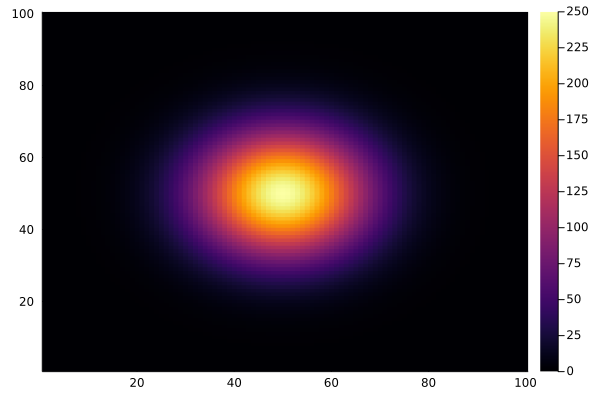

In [8]:
heatmap(T₀, clim=(0, maximum(T₀)))

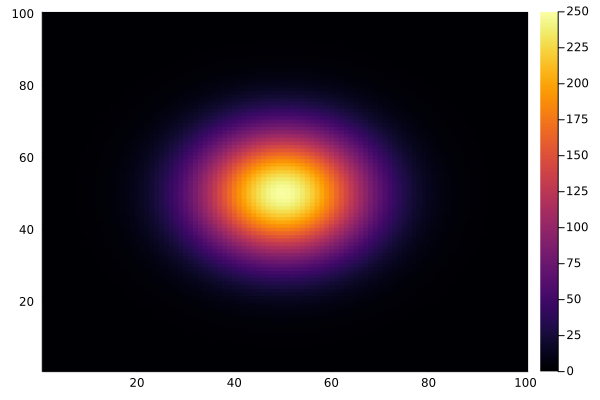

In [9]:
heatmap(T₁, clim=(0, maximum(T₀)))

Notice that the changes in the temperature field are really small:

In [10]:
sqrt( sum((T₁.-T₀).^2) / (nx * ny) )

0.16311579618178718